# Clean and analyse tweets
We will clean the Twitter data and then create additional features based on the message text. This code draws heavily on cleaning code I produced previously for Visual Analytics coursework, which in turn was inspired by https://ourcodingclub.github.io/tutorials/topic-modelling-python/

First load the file of twitter data created by 1_6 Get Tweets

In [106]:
import os
import tweepy
import datetime
import pandas as pd
import numpy as np
from glob import glob

## 1. Load prefetched Twitter data
We want to loadmultiple files and merge them into a single dataframe - the following code is inspired by https://towardsdatascience.com/6-pandas-tricks-you-should-know-to-speed-up-your-data-analysis-d3dec7c29e5

In [107]:
files = sorted(glob("./DataSources/TwitterData/raw_tweets_*.csv"))
files

['./DataSources/TwitterData\\raw_tweets_20210728.csv',
 './DataSources/TwitterData\\raw_tweets_20210729.csv',
 './DataSources/TwitterData\\raw_tweets_20210730.csv']

In [108]:
all_tweets_raw = pd.concat(pd.read_csv(file) for file in files)
print(all_tweets_raw.shape)
all_tweets_raw.head()

(26798, 14)


,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,tweeter_coordinates,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,extract_run_date,retrieved_using_search_term
0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,NaN,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime
1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,NaN,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,20210728,London AND knife AND crime
2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,NaN,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime
3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,NaN,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime
4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,NaN,NaN,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime


## 2. Clean twitter data and extract features ready for analysis

### 2.1 Cleaning

#### 2.1.1 Remove duplicates
We are loading data from multiple files and based on multiple search terms and so this means a single tweet might be duplicated multiple times. Therefore, we remove duplicates based on tweet_id, which is a unique identifier
- Each object within Twitter - a Tweet, Direct Message, User, List, and so on - has a unique ID (https://developer.twitter.com/en/docs/twitter-ids)

In [109]:
all_tweets = all_tweets_raw.drop_duplicates(subset=['tweet_id']).reset_index()
print(all_tweets.shape)
all_tweets.head()

(20011, 15)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,tweeter_coordinates,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,extract_run_date,retrieved_using_search_term
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,NaN,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,NaN,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,20210728,London AND knife AND crime
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,NaN,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,NaN,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,NaN,NaN,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime


#### 2.1.2 Remove NaN values

In [110]:
all_tweets = all_tweets.dropna(how='all') # only drops a row when every column is NA

all_tweets.shape

(20011, 15)

In [111]:
# Now check for individual NaN values
nan_values = all_tweets[all_tweets.isna().any(axis=1)]
print(nan_values.count())

index                           20011
tweet_id                        20011
tweet_date                      20011
tweeter_id                      20011
tweeter_user_name               20009
tweeter_screen_name             20011
tweeter_location                13189
tweeter_coordinates                 1
message_text                    20011
in_reply_to_user_screen_name     1630
quote_tweet_screen_name           280
favourite_count                 20011
retweet_count                   20011
extract_run_date                20011
retrieved_using_search_term     20011
dtype: int64


##### Comments
- tweeter_coordinates is nearly always NaN so drop it
- tweeter_location is often NaN so set it to "unknown"
- it's OK if in_reply_to_user_screen_name = Nan, just set to blanks
- it's OK if quote_tweet_screen_name = Nan, just set to blanks

In [112]:
all_tweets.drop('tweeter_coordinates', axis=1, inplace=True)

all_tweets.loc[all_tweets['tweeter_location'].isna(), 'tweeter_location'] = 'unknown'
all_tweets.loc[all_tweets['in_reply_to_user_screen_name'].isna(), 'in_reply_to_user_screen_name'] = ''
all_tweets.loc[all_tweets['quote_tweet_screen_name'].isna(), 'quote_tweet_screen_name'] = ''

nan_values = all_tweets[all_tweets.isna().any(axis=1)]
print(nan_values.count())
nan_values.head()

index                           2
tweet_id                        2
tweet_date                      2
tweeter_id                      2
tweeter_user_name               0
tweeter_screen_name             2
tweeter_location                2
message_text                    2
in_reply_to_user_screen_name    2
quote_tweet_screen_name         2
favourite_count                 2
retweet_count                   2
extract_run_date                2
retrieved_using_search_term     2
dtype: int64


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,extract_run_date,retrieved_using_search_term
10855,1743,1420847689441419278,2021-07-29 20:44:21,996022000605855744,NaN,SMorris48073327,unknown,RT @GoodLawProject: Government used public mon...,,,0,1198,20210730,sadiq AND khan
14558,5466,1420680783296176134,2021-07-29 09:41:08,996022000605855744,NaN,SMorris48073327,unknown,RT @GoodLawProject: BREAKING: New emails revea...,,,0,4299,20210730,sadiq AND khan


##### Comments - round 2
Don't worry about rows where tweeter_user_name is NaN because we use the tweeter_screen_name rather than tweeter_user_name
No other columns with nulls

#### 2.1.3 Remove tweets that don't contain meaningful text
I define meaningful as containing more than 4 characters.
- Also remove rows where message text comprises up to 15 blanks

In [113]:
all_tweets = all_tweets[all_tweets['message_text'].str.len() > 4]

print(all_tweets.shape)

(20011, 14)


In [114]:
all_tweets['message_text'] = all_tweets['message_text'].fillna('')
all_tweets['message_text'].replace('', np.nan, inplace=True)
all_tweets['message_text'].replace(' ', np.nan, inplace=True)
all_tweets['message_text'].replace('   ', np.nan, inplace=True)
all_tweets['message_text'].replace('    ', np.nan, inplace=True)
all_tweets['message_text'].replace('     ', np.nan, inplace=True)
all_tweets['message_text'].replace('      ', np.nan, inplace=True)
all_tweets['message_text'].replace('       ', np.nan, inplace=True)
all_tweets['message_text'].replace('        ', np.nan, inplace=True)
all_tweets['message_text'].replace('         ', np.nan, inplace=True)
all_tweets['message_text'].replace('          ', np.nan, inplace=True)
all_tweets['message_text'].replace('           ', np.nan, inplace=True)
all_tweets['message_text'].replace('            ', np.nan, inplace=True)
all_tweets['message_text'].replace('             ', np.nan, inplace=True)
all_tweets['message_text'].replace('              ', np.nan, inplace=True)
all_tweets['message_text'].replace('               ', np.nan, inplace=True)
all_tweets['message_text'].replace('                ', np.nan, inplace=True)
all_tweets['message_text'].replace('                 ', np.nan, inplace=True)
all_tweets['message_text'].replace('                  ', np.nan, inplace=True)
all_tweets['message_text'].replace('                   ', np.nan, inplace=True)
all_tweets['message_text'].replace('                    ', np.nan, inplace=True)
all_tweets['message_text'].replace('                     ', np.nan, inplace=True)
all_tweets['message_text'].replace('                              ', np.nan, inplace=True)
all_tweets['message_text'].replace('                                                                        ', np.nan, inplace=True)
all_tweets['message_text'].replace('                                                                                                                     ', np.nan, inplace=True)

all_tweets.dropna(subset=['message_text'], inplace=True)

print(all_tweets.shape)

(20011, 14)


#### 2.1.4 Strip out noise from Tweet message text
Code taken from Visual Analytics_Lab08 (Text)

In [115]:
def preprocess(message_text):
    message_text = message_text.str.replace("(<br/>)", "")
    message_text = message_text.str.replace('(<a).*(>).*(</a>)', '')
    message_text = message_text.str.replace('(&amp)', '')
    message_text = message_text.str.replace('(&gt)', '')
    message_text = message_text.str.replace('(&lt)', '')
    message_text = message_text.str.replace('(\xa0)', ' ')  
    return message_text


all_tweets['message_text'] = preprocess(all_tweets['message_text'])

### 2.1 Cleaning Comments
We now have a dataframe with duplicates and NaN values removed and noise removed from the Twitter message text. The next step is to enrich/transform our data 

### 2.2 Enrich Twitter data - Functions
What we're trying to do now is get an idea of what is in our body of tweets and we do this by extracting retweets, mentions and hashtags, which we can use to get an overview of what was being discussed on Twitter.
We can then visualise these in terms of both treemaps and word clouds just get an overview before creating NGRAMS to see which are the most commonly grouped terms. 

Getting an idea of what's being discussed also helps us discard conversations that are not relevant for our research.

- This code draws heavily from the coursework submitted for Visual Analytics, which in turn was inspired by https://ourcodingclub.github.io/tutorials/topic-modelling-python/

#### 2.2.1 Functions for deriving who was retweeted, mentioned or which hashtags were used

In [116]:
import re

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet.lower())   

def get_rt_mentions_hash(df, col_name):
    df['retweeted'] = df[col_name].apply(find_retweeted)
    df['mentioned'] = df[col_name].apply(find_mentioned)
    
    df['hashtags'] = df[col_name].apply(find_hashtags)
    
    return df

#### 2.2.2 Functions to prepare data for wordclouds, NGRAMs
This code was based on coursework submitted for VisualAnalytics

In [117]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')

def remove_links(text):
    '''Takes a string and removes web links from it'''
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    return text

def remove_users(text):
    '''Takes a string and removes retweet and @user information'''
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove retweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove tweeted at
    return text

def remove_punct(text):
    text = remove_users(text)
    text = remove_links(text)
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text.lower()
    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def tokenization(text):
    text = word_tokenize(text)
    return text

def remove_stopwords(text):
    stop_words = (stopwords.words('english'))
    stop_words.extend(['a','all','and','but','come','could','day','even',
             'he','it','if','i','on','like','man','made','men','must',
             'one','see','she','said','say','sort',
             'still','the','that','to','they','this','then','there',
             'would','two','what','you','-','_','—','***','rt', 'via','http',
             'London','london','xxx','xx','bong','got',
             'seen', 'sure', 'dont','gon','na','wan', 'uk',
             'united kingdom','britain','ffs','british','un','hahaha','haha','hahahaha','britains'])  
    
    text = [w for w in text if not w in stop_words]
    return text

def lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w, pos='a') for w in text]
    return text

def recreate_tweet(word_list):
    tweet = ' '.join([w for w in word_list])
    return tweet
    
def get_hashtags(tweet):
    hash_tags= [i  for i in tweet.split() if i.startswith("#") ]
    return " ".join(hash_tags)

def get_clean_lemmatized(df, col_name):
    df['Tweet_punct'] = df[col_name].apply(lambda x: remove_punct(x))
    df['Tweet_tokenized'] = df['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
    df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
    df['Tweet_lemmatized'] = df['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
    df['Clean_MessageText'] = df['Tweet_lemmatized'].apply(lambda x: recreate_tweet(x))
    
    # create a single text string for all hash tags and for all clean text
    hash_tags = get_hashtags(" ".join(ttext for ttext in df[col_name]))
    all_clean_words = " ".join(ttext for ttext in df['Clean_MessageText']) # code taken from VA_Lab08 (Text)
    
    return df, hash_tags, all_clean_words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 2.2.3 Helper functions for Correlation, Treemap and Wordcloud plots

##### 2.2.3.1 Get popular hashtags
THis includes functions to derive correlations between hashtags # Code very gratefully borrowed from 
https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

In [118]:
# take the rows from the hashtag columns where there are actually hashtags
def get_popular_hashtags(df, min_appearance):
    hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

    # create dataframe where each use of hashtag gets its own row
    flattened_hashtags_df = pd.DataFrame(
        [hashtag for hashtags_list in hashtags_list_df.hashtags
        for hashtag in hashtags_list],
        columns=['hashtag'])

    # count of appearances of each hashtag
    popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    
    # now create a matrix of popular hashtags so we can see how they correlate
    popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

    # make a new column with only the popular hashtags
    hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
    # drop rows without popular hashtag
    popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

    # make new dataframe
    hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

    for hashtag in popular_hashtags_set:
        # make columns to encode presence of hashtags
        hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
            lambda hashtag_list: int(hashtag in hashtag_list))
    
    # Now satisfied we will drop the popular_hashtags column from the dataframe. We don’t need it.
    hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)
    
    return popular_hashtags, hashtag_matrix


# Code very gratefully borrowed from 
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

##### 2.2.3.2 Get popular retweeted
Similar code to above
- take the rows from the hashtag columns where there are actually hashtags

In [119]:
def get_popular_retweets(df):
    retweeted_list_df = df.loc[
                       df.retweeted.apply(
                           lambda retweeted_list_df: retweeted_list_df !=[]
                       ),['retweeted']]

    # create dataframe where each use of hashtag gets its own row
    flattened_retweeted_df = pd.DataFrame(
        [retweeted for retweeted_list in retweeted_list_df.retweeted
        for retweeted in retweeted_list],
        columns=['retweeted'])

    # count of appearances of each hashtag
    popular_retweeted = flattened_retweeted_df.groupby('retweeted').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    
    return popular_retweeted

##### 2.2.3.3 Get popular mentions

In [120]:
def get_popular_mentioned(df):
    mentioned_list_df = df.loc[
                       df.mentioned.apply(
                           lambda mentioned_list_df: mentioned_list_df !=[]
                       ),['mentioned']]

    # create dataframe where each use of hashtag gets its own row
    flattened_mentioned_df = pd.DataFrame(
        [mentioned for mentioned_list in mentioned_list_df.mentioned
        for mentioned in mentioned_list],
        columns=['mentioned'])

    # count of appearances of each hashtag
    popular_mentioned = flattened_mentioned_df.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    
    return popular_mentioned

### 2.3 Enrich Twitter data - execute functions
We will enrich the dataframe with the following data:
- Who was retweeted, mentioned or which hashtags were used
- which were the most popular retweets, mentions or hastags
- Single text strings for all hash tags and for all clean text (cleaned, lemmatized) for use in the word clouds

In [121]:
all_tweets = get_rt_mentions_hash(all_tweets, 'message_text')
all_tweets, hash_tags, all_clean_words = get_clean_lemmatized(all_tweets, 'message_text')

popular_hashtags, hashtag_matrix = get_popular_hashtags(all_tweets, 10)
popular_retweeted = get_popular_retweets(all_tweets)
popular_mentioned = get_popular_mentioned(all_tweets)
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

### 2.4 Plot Correlations, Treemaps, Wordclouds and NGrams
Having enriched the dataset, we can now analyse the data

#### 2.4.1 hashtag correlations and top hashtags

<Figure size 1440x1440 with 0 Axes>

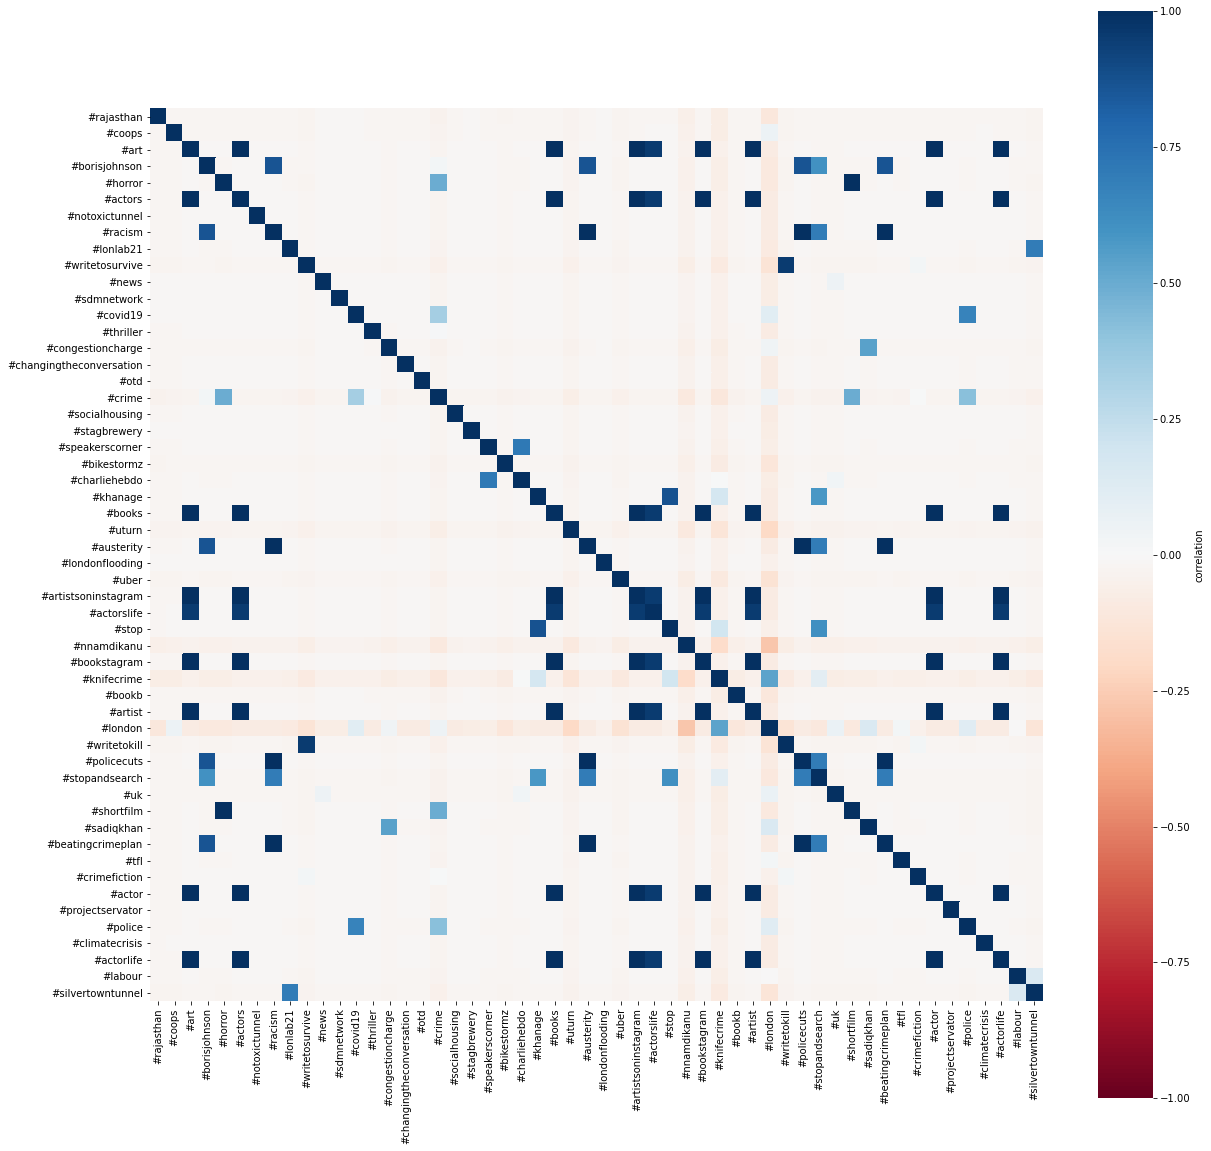

In [122]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# plot the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

In [123]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(hashtag_matrix, 25))

Top Absolute Correlations
#bookstagram  #artist                1.0
#art          #actors                1.0
#horror       #shortfilm             1.0
#art          #artistsoninstagram    1.0
#bookstagram  #actor                 1.0
#art          #bookstagram           1.0
#bookstagram  #actorlife             1.0
#art          #artist                1.0
              #actor                 1.0
              #actorlife             1.0
#artist       #actor                 1.0
              #actorlife             1.0
#racism       #beatingcrimeplan      1.0
              #policecuts            1.0
              #austerity             1.0
#policecuts   #beatingcrimeplan      1.0
#actors       #actorlife             1.0
              #actor                 1.0
              #artist                1.0
              #bookstagram           1.0
              #artistsoninstagram    1.0
#art          #books                 1.0
#actors       #books                 1.0
#austerity    #beatingcrimeplan

#### 2.4.2 Treemaps
Produce treemaps to visualise most popular hashtags, mentions and retweets

In [124]:
# now lets get the top 100 hashtags into a treemap - where #london or #London is not present
import squarify

def plot_popular_hashtags(df, count):
    most_popular_hashtags = df[(df.hashtag!='#London') & 
                                        (df.hashtag!='#london')][:count]

    plt.figure(figsize=(20,20))
    squarify.plot(sizes=most_popular_hashtags['counts'], 
              label=most_popular_hashtags['hashtag'], alpha=.8 )
    plt.axis('off')
    plt.show()
    
def plot_popular_retweets(df, count):
    # now lets get the top 100 retweets into a treemap 
    most_popular_retweets = df[:count]

    plt.figure(figsize=(20,20))
    squarify.plot(sizes=most_popular_retweets['counts'], 
              label=most_popular_retweets['retweeted'], alpha=.8 )
    plt.axis('off')
    plt.show()
    
def plot_popular_mentions(df, count):
    # now lets get the top 100 mentioned into a treemap 
    most_popular_mentioned = df[:count]

    plt.figure(figsize=(20,20))
    squarify.plot(sizes=most_popular_mentioned['counts'], 
              label=most_popular_mentioned['mentioned'], alpha=.8 )
    plt.axis('off')
    plt.show()

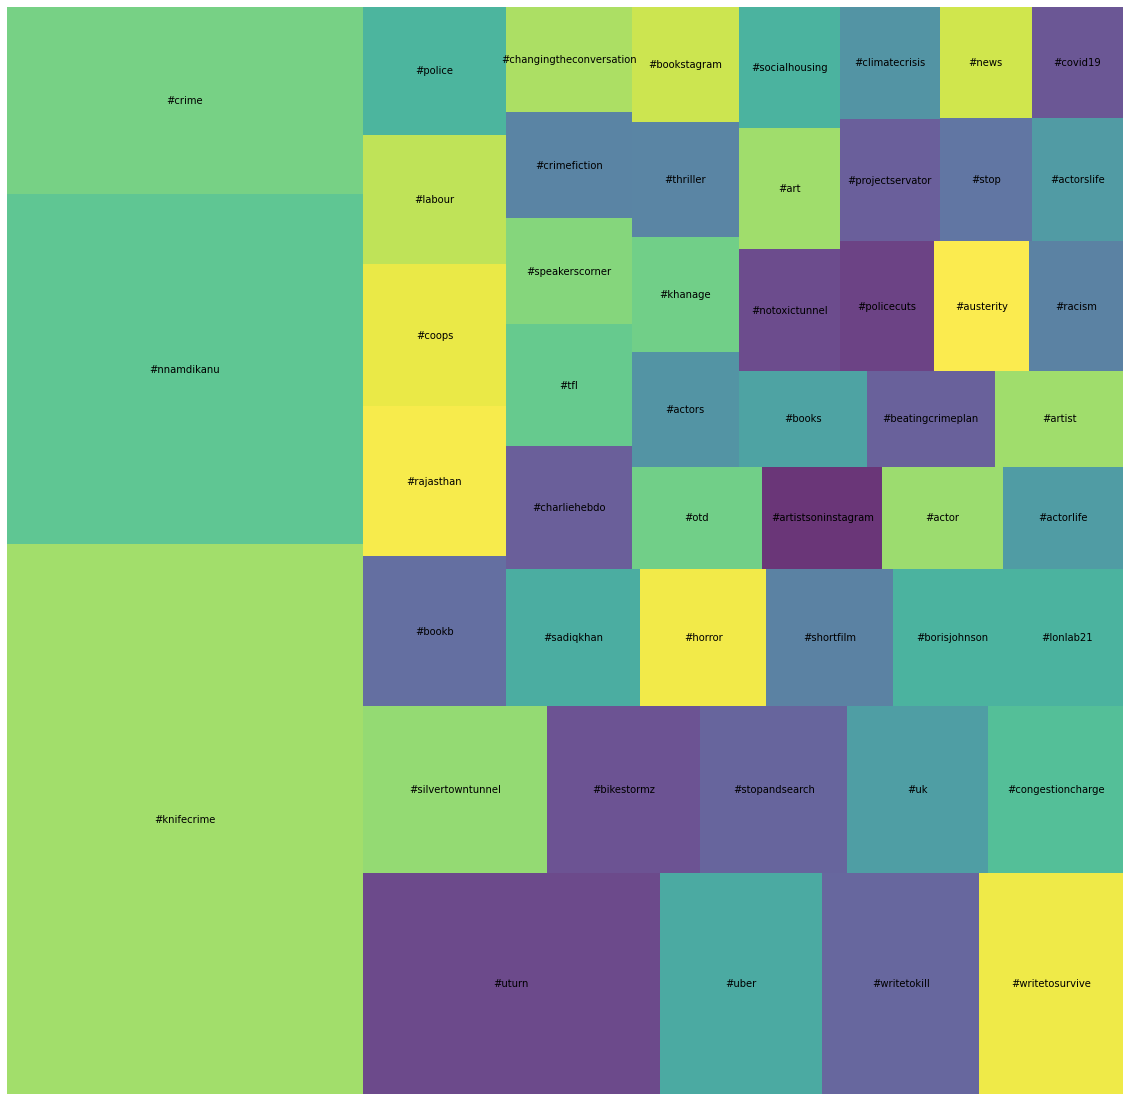

In [125]:
my_count = 50
plot_popular_hashtags(popular_hashtags, my_count)

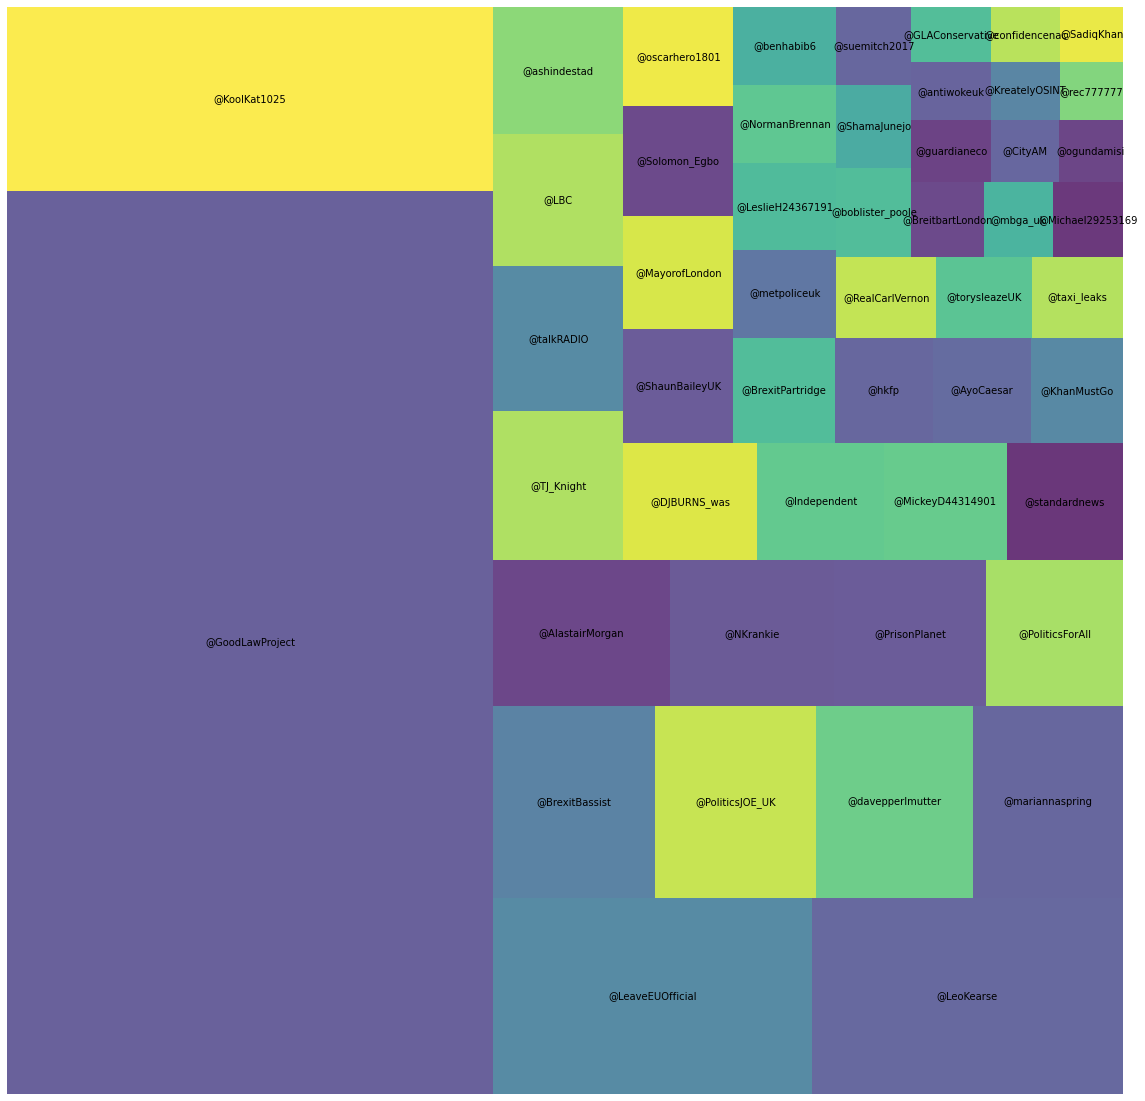

In [126]:
plot_popular_retweets(popular_retweeted, my_count)

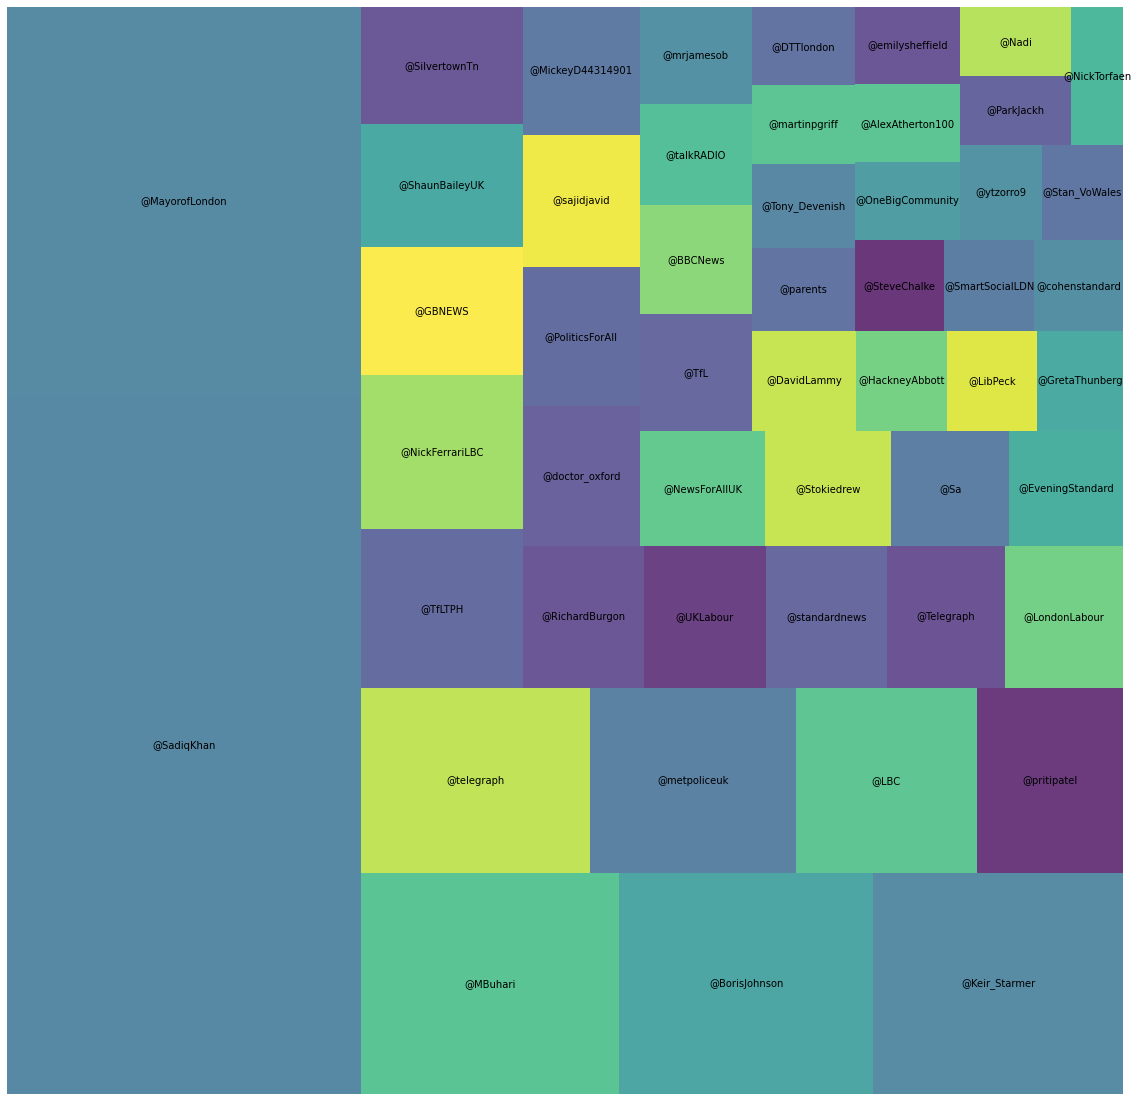

In [127]:
plot_popular_mentions(popular_mentioned, my_count)

In [128]:
popular_hashtags[:30]

,hashtag,counts
0,#london,351
1,#knifecrime,191
2,#nnamdikanu,122
3,#crime,65
4,#uturn,64
5,#uber,35
6,#writetokill,34
7,#writetosurvive,31
8,#silvertowntunnel,30
9,#bikestormz,25


In [129]:
popular_mentioned[:30]

,mentioned,counts
0,@SadiqKhan,544
1,@MayorofLondon,305
2,@MBuhari,126
3,@BorisJohnson,124
4,@Keir_Starmer,122
5,@telegraph,94
6,@metpoliceuk,84
7,@LBC,74
8,@pritipatel,60
9,@TfLTPH,57


In [130]:
popular_retweeted[:30]

,retweeted,counts
0,@GoodLawProject,4473
1,@KoolKat1025,911
2,@LeaveEUOfficial,637
3,@LeoKearse,623
4,@BrexitBassist,316
5,@PoliticsJOE_UK,314
6,@davepperlmutter,307
7,@mariannaspring,293
8,@AlastairMorgan,262
9,@NKrankie,244


#### 2.4.3 Produce wordclouds
Produce wordclouds for all words and also for most popular hashtags. Also 

In [131]:
# Create and generate word cloud images:
# create one for all words (with # symbol removed) and another with hash_tags
# code taken from VA_Lab08 (Text)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def plot_wordcloud(df, description):
    wordcloud_all = WordCloud(max_font_size=50, min_font_size=8, max_words=150, background_color="white",
                     width=800, height=400, prefer_horizontal=0.99).generate(df)
    
    # Display the generated image:
    _ = plt.figure(figsize = (16, 8))
    _ = plt.imshow(wordcloud_all, interpolation='bilinear')
    _ = plt.axis("off")
    
    description_ = "\n ----------- " + description + " ---------- \n"
    print(description_)
    plt.show()

# I want to see how many unique words
# code inspired by DataScience_Lab08
from nltk import FreqDist

def unique_words(in_text):
    text_tokens = word_tokenize(in_text)
    fdist_example = FreqDist(text_tokens)
    word_freq = dict((text_tokens, freq) for text_tokens, freq in fdist_example.items())

    return word_freq


 ----------- ALL WORDS ---------- 



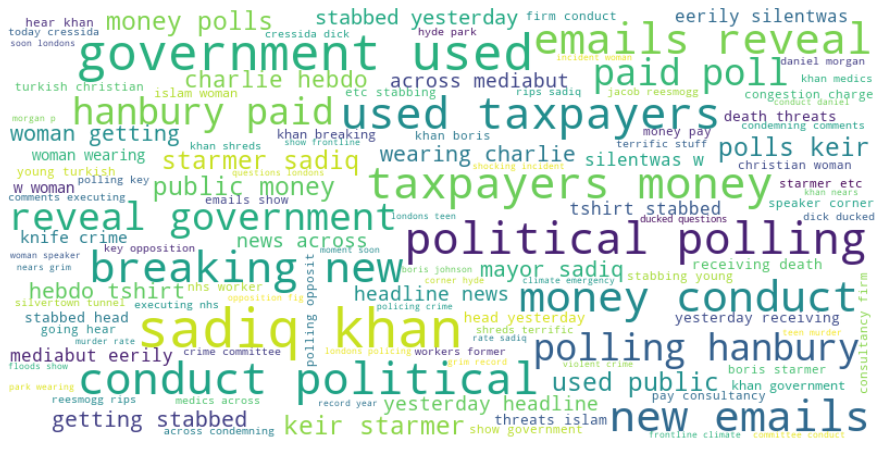


 ----------- HASH TAGS ---------- 



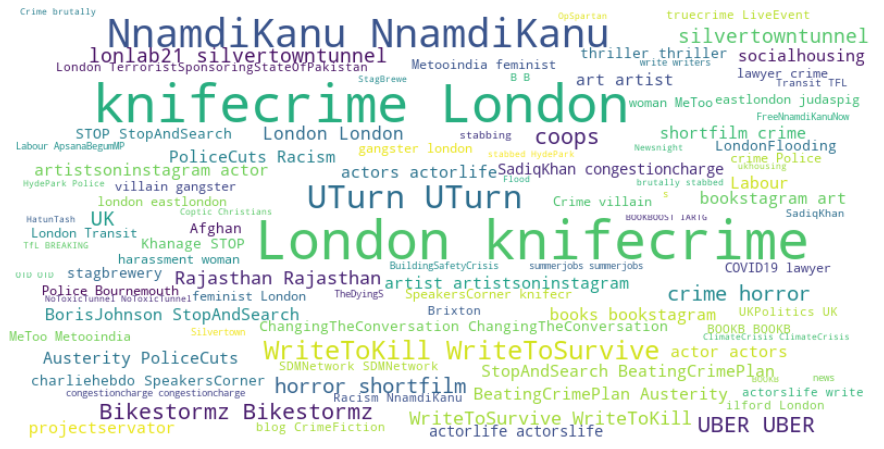

Number of all words = 8223
Number of hash_tags = 494


In [132]:
plot_wordcloud(all_clean_words, 'ALL WORDS')
plot_wordcloud(hash_tags, 'HASH TAGS')

unique_all = unique_words(all_clean_words)
unique_hashtag = unique_words(hash_tags)

print("Number of all words = " + str(len(unique_all))) # we have 462922 unique words
print("Number of hash_tags = " + str(len(unique_hashtag))) 

#### 2.4.4 Plot N Grams
We plot most frequently occuring words, bigrams and trigrams

In [133]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
#import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
#from sklearn.decomposition import TruncatedSVD
#from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_k_n_gram(corpus, k=None, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]

def get_all_n_gram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

Loading BokehJS ...

In [134]:
def plot_ngrams(df, col_name):

    common_words = get_top_n_words(df[col_name], 25)
    df1 = pd.DataFrame(common_words, columns = [col_name, 'count'])
    df1.groupby(col_name).sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title='Top 25 words in clean message text')

    common_bigrams = get_top_k_n_gram(df[col_name], 25,2)
    df3 = pd.DataFrame(common_bigrams, columns = [col_name , 'count'])
    df3.groupby(col_name).sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title='Top 25 bigrams in clean message text')

    common_trigrams = get_top_k_n_gram(df[col_name], 25,3)
    df5 = pd.DataFrame(common_trigrams, columns = [col_name , 'count'])
    df5.groupby(col_name).sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title='Top 25 trigrams in clean message text')
    

In [135]:
plot_ngrams(all_tweets, 'Clean_MessageText')

### 2.5 Comments and required pruning
We want to remove tweets that aren't related to either knife or serious violent crime and to do this we review our results above and extract irrelevant tweets. We need to do this for each different run because as said previously we are downloading data on a weekly basis, and then accumulating the data into a single dataframe. 

This means the topics under discussion each week will change and so the cleaning we perform will be specific to that weeks data. Therefore we are explicit as to which cleaning is related to which weeks

#### 2.5.1 Data loaded 26/07/2021

##### Bigrams/words to exclude
- Sunday Igboho, Benin: is a Nigerian separatist who was arrested in the Benin republic so these tweets are not of interest for this research. 
- Daniel Morgan: The findings from an inquiry into the Metropolitan Police's handing of the Daniel Morgan murder was recently published and this report was highly critical of both the police and also the Police Commissioner's actions during the inquiry. This is slightly more difficult to exclude because we don't want to remove tweets relating to Cressida Dick because, as current Commissioner, she could also be mentioned in tweets relating to serious violent crime. Therefore in this case we just delete tweets with morgan in the text.

##### hashtags to exclude
Great timing (?) but there was a lot of discussions about crime thrillers and we wish to exlude these
- #WriteToKill
- #WriteToSurvive
- #CrimeFiction
- #kindle
- #thriller
- #artistsoninstagram
- #actorlife
- #actorslife
- #bookstagram


##### retweets to exclude
Lots of retweets of authors and singers, which aren't important to us
@Xpsilver1	- Musician, plus also activist talking about issues in Nigeria
@AlastairMorgan	- in news, talking/writing about murder of his brother Daniel Morgan
@davepperlmutter - thriller writer	

##### mentions to exclude
@ParkJackh - a horror writer

#### 2.5.2 Data loaded 01/08/2021
##### retweets to exclude
GoodLawProject published report on government using taxpayer money for private polling
- @GoodLawProject	

##### hashtags to exclude
 SilverTown tunnel flared up with Climate crisis
- #silvertowntunnel
- #climatecrisis
- #uber
- #nnamdianu
- #uturn

### 2.6 Prune data

In [136]:
def prune_messages(df, exclude_hashtags, exclude_names, exclude_rt_mentions):
    df['exclude_item'] = 0
    df['exclude_item'][df.message_text.str.contains('|'.join(exclude_hashtags),case=False)] = 1
    df['exclude_item'][df.message_text.str.contains('|'.join(exclude_names),case=False)] = 1    
    df['exclude_item'][df.message_text.str.contains('|'.join(exclude_rt_mentions),case=False)] = 1
    
    df_new = df[df.exclude_item==0].copy().reset_index()
    return df_new

In [167]:
exclude_hashtags = ['#WriteToKill', '#WriteToSurvive', '#CrimeFiction', '#kindle', '#thriller','#artistsoninstagram',
                  '#actorlife', '#actorslife', '#bookstagram', '#ClimateCrisis', '#silvertowntunnel', '#NnamdiKanu', '#UBER']

exclude_hashtags = ['#writetokill', '#writetosurvive', '#crimefiction', '#kindle', '#thriller','#artistsoninstagram',
                  '#actorlife', '#actorslife', '#bookstagram', '#climatecrisis', '#silvertowntunnel', '#nnamdikanu', 
                    '#uber', '#uturn']

exclude_names = ['igboho', 'benin', 'daniel morgan']

exclude_rt_mentions = ['@Xpsilver1', '@AlastairMorgan', '@davepperlmutter', '@ParkJackh', '@GoodLawProject']

all_tweet_cleaned_raw = prune_messages(all_tweets, exclude_hashtags, exclude_names, exclude_rt_mentions)

print(all_tweets.shape)
all_tweet_cleaned_raw.shape

(20011, 23)


(14623, 24)

#### 2.6.1 Recreate pruned dataset
I need to regenerate the message text, hashtags, retweets etc based on the pruned dataframe
- First I need to drop these columns from the new dataframe

In [168]:
copy_fields = ['tweet_id',
              'tweet_date',
              'tweeter_id',
              'tweeter_user_name',
              'tweeter_screen_name',
              'tweeter_location',
              'message_text',
              'in_reply_to_user_screen_name',
              'quote_tweet_screen_name',
              'favourite_count',
              'retweet_count',
              'extract_run_date',
              'retrieved_using_search_term']
all_tweet_cleaned = all_tweet_cleaned_raw[copy_fields].copy().reset_index()

In [169]:
all_tweet_cleaned = get_rt_mentions_hash(all_tweet_cleaned, 'message_text')
all_tweet_cleaned, hash_tags_cleaned, all_clean_words_cleaned = get_clean_lemmatized(all_tweet_cleaned, 'message_text')

## 3. Analyse pruned data

In [170]:
popular_hashtags_cleaned, hashtag_matrix_cleaned = get_popular_hashtags(all_tweet_cleaned, 10)
popular_retweeted_cleaned = get_popular_retweets(all_tweet_cleaned)
popular_mentioned_cleaned = get_popular_mentioned(all_tweet_cleaned)

In [171]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(hashtag_matrix_cleaned, 25))

Top Absolute Correlations
#racism            #austerity           1.000000
#policecuts        #beatingcrimeplan    1.000000
#racism            #policecuts          1.000000
#austerity         #beatingcrimeplan    1.000000
#racism            #beatingcrimeplan    1.000000
#austerity         #policecuts          1.000000
#khanage           #stop                0.867945
#borisjohnson      #policecuts          0.863158
                   #beatingcrimeplan    0.863158
                   #austerity           0.863158
                   #racism              0.863158
#speakerscorner    #charliehebdo        0.709584
#policecuts        #stopandsearch       0.700059
#austerity         #stopandsearch       0.700059
#stopandsearch     #beatingcrimeplan    0.700059
#racism            #stopandsearch       0.700059
#covid19           #police              0.664160
#stop              #stopandsearch       0.606356
#borisjohnson      #stopandsearch       0.600077
#khanage           #stopandsearch       0.5

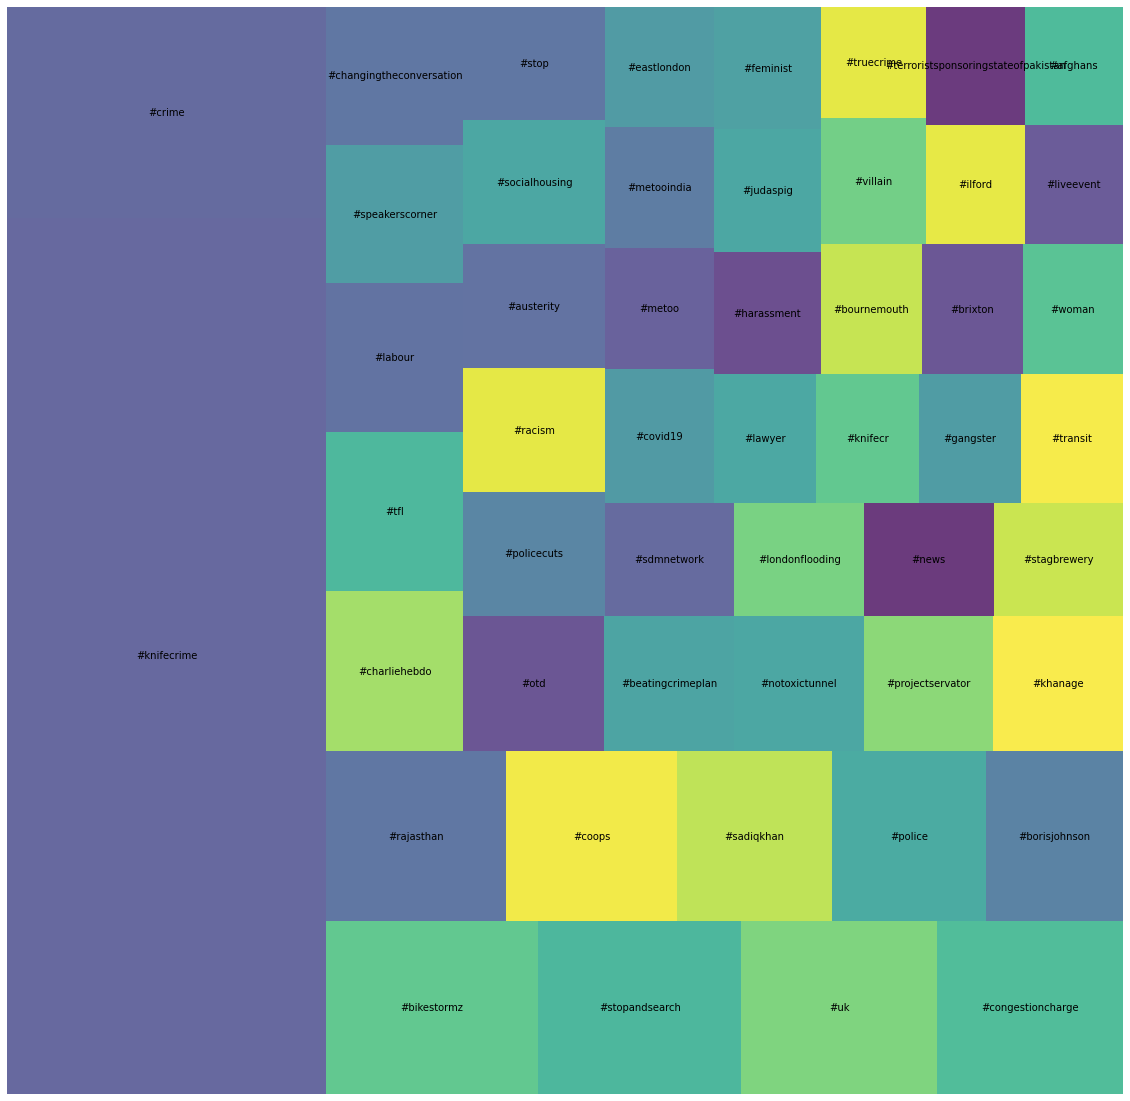

In [172]:
plot_popular_hashtags(popular_hashtags_cleaned, my_count)

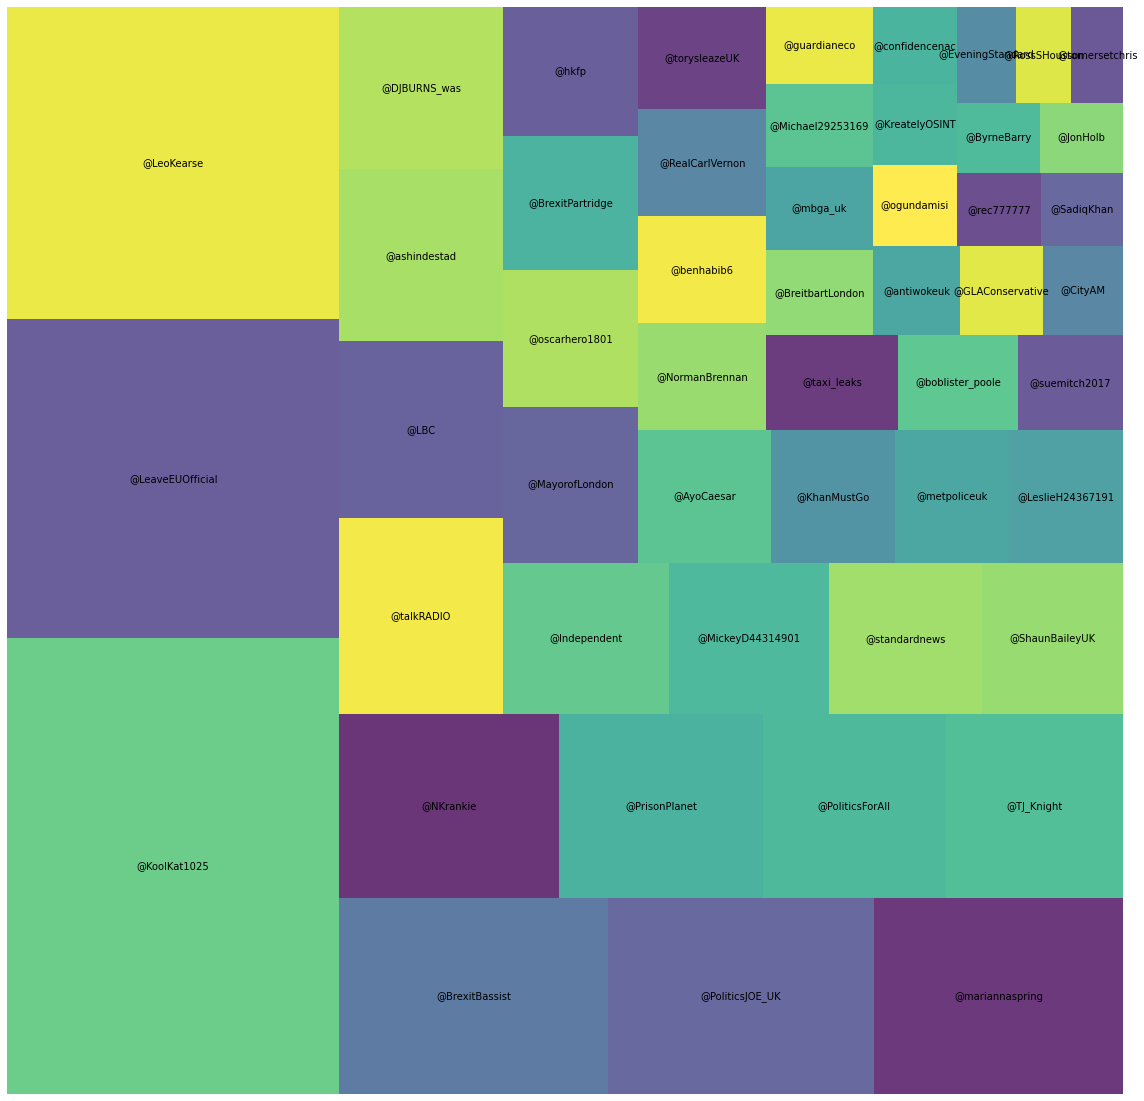

In [173]:
plot_popular_retweets(popular_retweeted_cleaned, my_count)

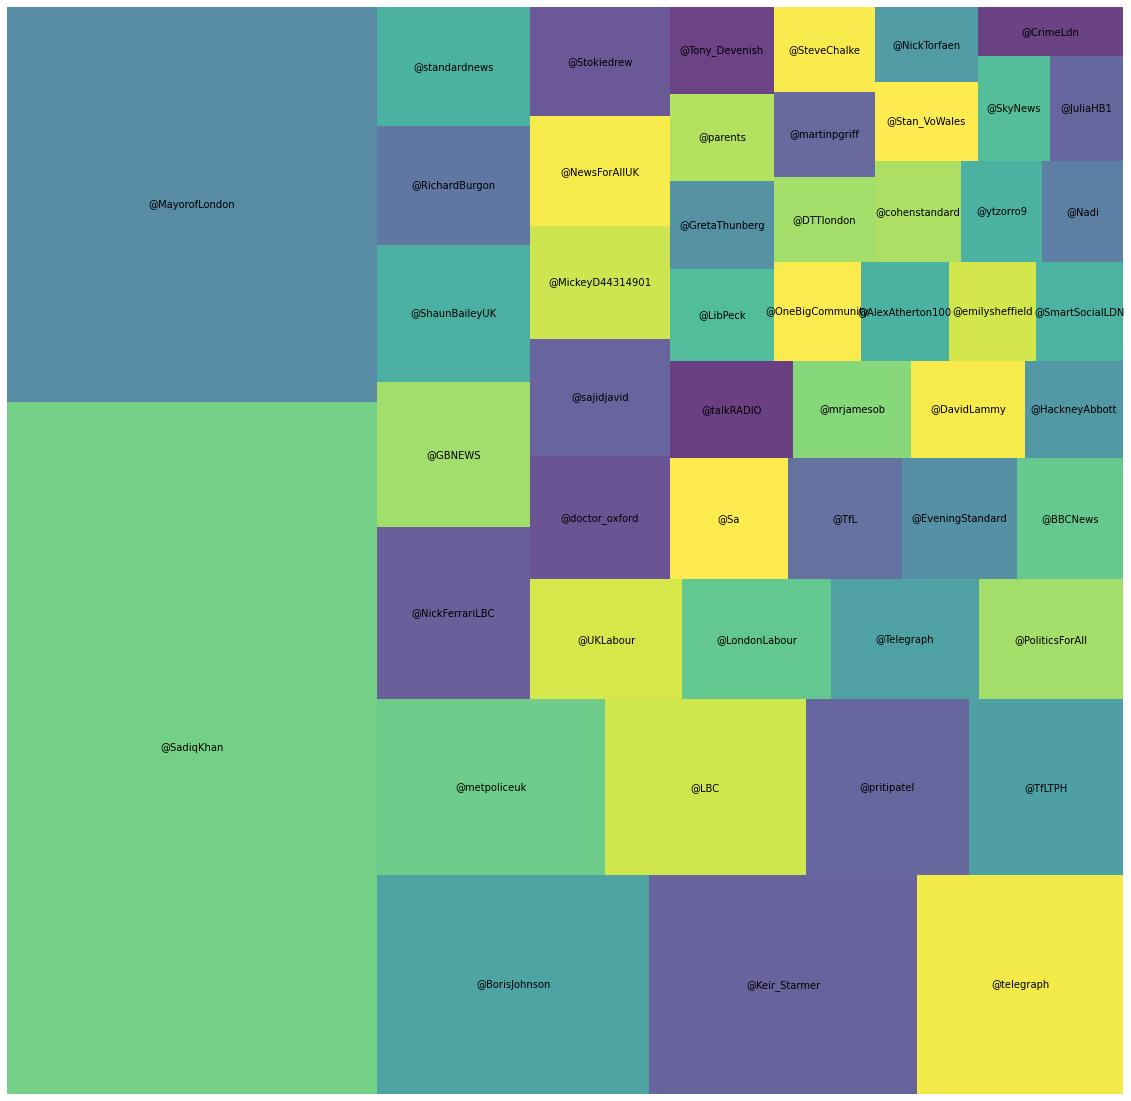

In [174]:
plot_popular_mentions(popular_mentioned_cleaned, my_count)

In [181]:
popular_hashtags_cleaned[:30]

,hashtag,counts
0,#london,349
1,#knifecrime,191
2,#crime,46
3,#bikestormz,25
4,#stopandsearch,24
5,#uk,23
6,#congestioncharge,22
7,#rajasthan,21
8,#coops,20
9,#sadiqkhan,18



 ----------- ALL WORDS ---------- 



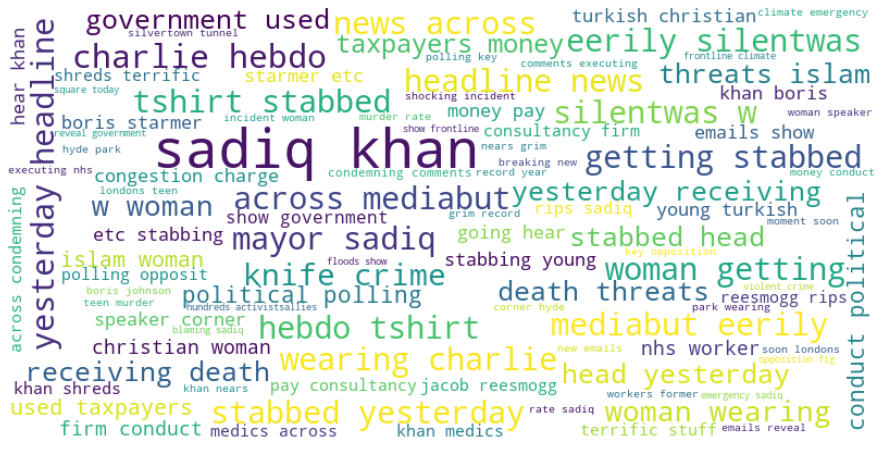


 ----------- HASH TAGS ---------- 



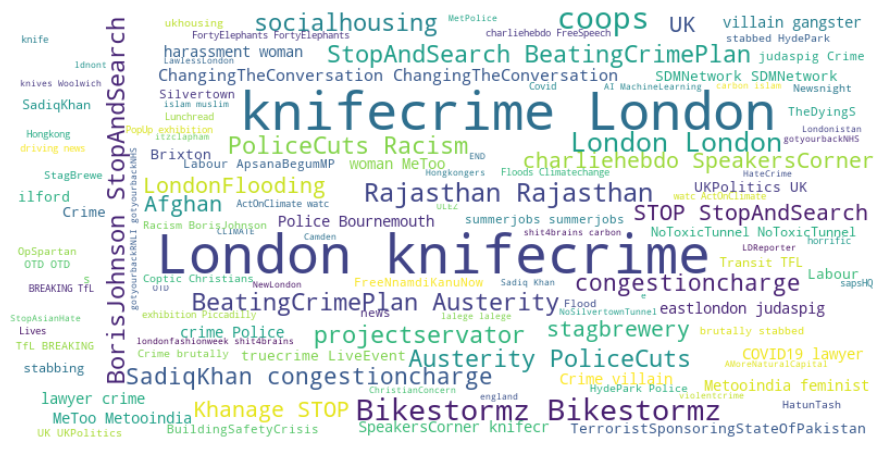

In [175]:
plot_wordcloud(all_clean_words_cleaned, 'ALL WORDS')
plot_wordcloud(hash_tags_cleaned, 'HASH TAGS')

unique_all = unique_words(all_clean_words_cleaned)
unique_hashtag = unique_words(hash_tags_cleaned)

In [176]:
print("Number of all words = " + str(len(unique_all))) # we have 462922 unique words
print("Number of hash_tags = " + str(len(unique_hashtag))) 

plot_ngrams(all_tweet_cleaned, 'Clean_MessageText')


Number of all words = 8138
Number of hash_tags = 439


### 3.1 Find where tweets originated

In [177]:
unknown_location = all_tweet_cleaned['tweeter_location'][all_tweets['tweeter_location'].str.contains('unknown')].count()
not_london = all_tweet_cleaned['tweeter_location'][(~all_tweet_cleaned['tweeter_location'].str.contains('London')) &
                                           (~all_tweet_cleaned['tweeter_location'].str.contains('unknown'))].count()

count_london = all_tweet_cleaned['tweeter_location'][all_tweet_cleaned['tweeter_location'].str.contains('London')].count()

unique_london = all_tweet_cleaned['tweeter_location'][all_tweet_cleaned['tweeter_location'].str.contains('London')].unique()

print('Number of tweets where location is not known is {}, while number of tweets originating outside London is {}'.format(unknown_location, not_london))
print('Number of tweets where location is London is {}, and these unique locations are as follows\n'.format(count_london))

unique_london

Number of tweets where location is not known is 4939, while number of tweets originating outside London is 7185
Number of tweets where location is London is 2448, and these unique locations are as follows



array(['London', 'Bexleyheath London England',
       'Chigwell London/Essex England', 'Sutton, London',
       'London, England', 'London & Oslo', 'Westminster, London',
       'South West England, ex London.', 'London ', 'London, UK',
       'East London.', 'London / New York / LA', 'SE London, Europe',
       'London E3', 'London, wish I was in Kerry',
       'London, United Kingdom', 'London, E14 2BG', 'Central London, UK',
       'Bromley, London', 'Ilford, London', 'Too close to London',
       'London, Chelmsford England, UK', 'Originally East London.',
       'South London', 'East London, UK', 'Camden Town, London',
       'Burdett Estate, London, E14', "TW8, It's a London thing",
       'Croydon, London',
       'London, England.                     Retweets/shares are not endorsements.',
       'London, England, UK', 'London Village, England', 'SE London',
       'East London', 'Ealing, London', 'Derry & London',
       'Enfield, London', 'Hammersmith, London', 'Brent, London

### 3.2 Now have a look at tweets by day/time

In [178]:
from datetime import timedelta
all_tweet_cleaned['tweet_date_dt'] = pd.to_datetime(all_tweets['tweet_date'])
all_tweet_cleaned['time_bins_12h'] = all_tweet_cleaned['tweet_date_dt'].dt.floor('12h')
all_tweet_cleaned['day_bins'] = all_tweet_cleaned['tweet_date_dt'].dt.day

all_tweets_time = all_tweet_cleaned.groupby(["time_bins_12h"]).apply(lambda x: x['time_bins_12h'].count()).reset_index()
all_tweets_time.rename(columns = {0:'count'}, inplace = True)

all_tweets_day = all_tweet_cleaned.groupby(["day_bins"]).apply(lambda x: x['day_bins'].count()).reset_index()
all_tweets_day.rename(columns = {0:'count'}, inplace = True)

In [179]:
import altair as alt
alt.data_transformers.disable_max_rows()

steelblue = 'rgb(70,130,180)'

tweet_by_hours_bar = alt.Chart(all_tweets_time, title='Tweet volume (every 12hrs)').mark_bar(
    opacity=0.6, color='firebrick', size=20).encode(
    x=alt.X('time_bins_12h:T', axis=alt.Axis(title='by half-day', ticks=False)),
    y=alt.Y('count:Q', axis=None),  
)

tweet_by_hours_text = alt.Chart(all_tweets_time).mark_text(
    align='center',
    baseline='middle',
    color='black',
    dy=-8 
).encode(
    x=alt.X('time_bins_12h:T', axis=alt.Axis(ticks=False)),
    y=alt.Y('count:Q', axis=None),
    text=alt.Text('count:Q', format=',')
)

tweet_by_days_bar = alt.Chart(all_tweets_day, title='Tweet volume by day').mark_bar(opacity=0.6, color='steelblue', size=20).encode(
    x=alt.X('day_bins:O', axis=alt.Axis(title='by day', ticks=False)),
    y=alt.Y('count:Q', axis=None),  
)

tweet_by_days_text = alt.Chart(all_tweets_day).mark_text(
    align='center',
    baseline='middle',
    color='black',
    dy=-8 
).encode(
    x=alt.X('day_bins:T', axis=alt.Axis(ticks=False)),
    y=alt.Y('count:Q', axis=alt.Axis(title='count', ticks=False)),  
    text=alt.Text('count:Q', format=',')
)

tweet_by_hours = (tweet_by_hours_bar + tweet_by_hours_text).properties(
    width=550,
    height=300)

tweet_by_days = (tweet_by_days_bar + tweet_by_days_text).properties(
    width=300,
    height=300)

(tweet_by_hours | tweet_by_days).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0)

DataTransformerRegistry.enable('default')

alt.HConcatChart(...)

## Final comments
Much more representative of knife crime so save data for use in social network analysis
- need some comments about key words and also when tweets are produced

### Now produce extract file for social group analysis

In [165]:
outputfile_str = "./DataSources/TwitterData/cleaned_tweets.csv"

all_tweet_cleaned.to_csv(outputfile_str, index=False)

In [166]:
all_tweets_df_new = pd.read_csv(outputfile_str)
print(all_tweets_df_new.shape)
all_tweets_df_new.head()

(14687, 25)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,extract_run_date,retrieved_using_search_term,retweeted,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,28
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,20210728,London AND knife AND crime,['@NaheedMajeed'],['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,28
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,28
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,28
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,28
